In [9]:
pip install tensorflow-datasets 

Note: you may need to restart the kernel to use updated packages.


In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, InputLayer


In [10]:
# loading the dataset
data, data_info = tfds.load('malaria',as_supervised=True,split='train',with_info=True,shuffle_files=True)

In [32]:
data_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Atharva Darke\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      im

In [12]:
list(data.take(1).as_numpy_iterator())

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  1)]

In [38]:
TRAIN_RATIO = 0.6
TEST_RATIO = 0.2
VAL_RATIO = 0.2

dataset = tf.data.Dataset.range(10)
DATA_SIZE = len(data)



In [54]:
def split_(dataset,TRAIN_RATIO,TEST_RATIO,VAL_RATIO):
    DATASET_SIZE = len(dataset)
    TRAIN_DATASET = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
    TEST_DATASET1 = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    TEST_DATASET = TEST_DATASET1.take(int(TEST_RATIO*DATASET_SIZE))
    VAL_DATASET = TEST_DATASET1.skip(int(VAL_RATIO*DATASET_SIZE))
    
    return TRAIN_DATASET, TEST_DATASET, VAL_DATASET

In [55]:
train,test,valid = split_(data,TRAIN_RATIO,TEST_RATIO,VAL_RATIO)

In [57]:
print(len(train),len(test),len(valid))

16534 5511 5513


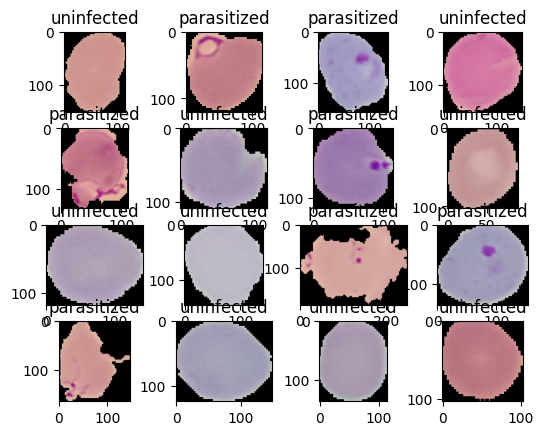

In [69]:
# visualizing the data
import matplotlib.pyplot as plt

for i,(image,label) in enumerate(train.take(16)):
    plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(data_info.features['label'].int2str(label))

In [76]:
# Preprocessing:

def preprocess(image,label):
    image_resized = tf.image.resize(image,size=[224,224],method='bilinear')/255
    return image_resized,label

In [77]:
train = train.map(preprocess)

In [80]:
model = tf.keras.Sequential([
                            InputLayer(shape=(224,224,3)),
                            Conv2D(filters=6,kernel_size=(5,5),strides=(1,1),padding='valid',activation='sigmoid'),
                            MaxPool2D(pool_size=(2,2),strides=2),

                            Conv2D(filters=16,kernel_size=(5,5),strides=(1,1),padding='valid',activation='sigmoid'),
                            MaxPool2D(pool_size=(2,2),strides=2),

                            Flatten(),

                            layers.Dense(100,activation='sigmoid'),
                            layers.Dense(10,activation='sigmoid'),
                            layers.Dense(2,activation='sigmoid')
])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 100)                 │       4,494,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,498,404 (17.16 MB)

 Trainable params: 4,498,404 (17.16 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
len(valid)

0

In [36]:
list(data.take(1).as_numpy_iterator())

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  1)]